# Section 5.1: Partial sensitivity analysis of multivariate database queries

In [1]:
from deuterium import Variable, to_vec, random_symbols, get_gradients
import numpy as np
from functools import partial
from sympy import sympify
import sympy as sy
import symengine as se
from scipy.optimize import shgo
import matplotlib.pyplot as plt

Set up a fictional database query

In [2]:
def f(a, b):
    return a*a +  np.exp(b*2 -a)

Create arrays of symbolic inputs of 5 individuals

In [3]:
x1 = to_vec(np.array(random_symbols(2, "x_1")))
x2 = to_vec(np.array(random_symbols(2, "x_2")))
x3 = to_vec(np.array(random_symbols(2, "x_3")))
x4 = to_vec(np.array(random_symbols(2, "x_4")))
x5 = to_vec(np.array(random_symbols(2, "x_5")))

Evaluate the function on the symbolic inputs

In [4]:
y1 = f(*x1)
y2 = f(*x2)
y3 = f(*x3)
y4 = f(*x4)
y5 = f(*x5)

In [5]:
sympify(y1.data).simplify(rational=True)

x_1_0**2 + exp(-x_1_0 + 2*x_1_1)

Define the aggregation function with Lipschitz constant 1

In [6]:
def aggregating_phi(ys):
    return np.mean(ys)

In [7]:
mean_output = aggregating_phi([y1, y2, y3, y4, y5])

In [8]:
y5

x_5_0**2 + exp(-x_5_0 + 2*x_5_1)

Calculate the gradients of the output of the mean function w.r.t the input variables of the individuals

In [9]:
mean_output_1 = get_gradients(mean_output, wrt=("x_1_0", "x_1_1"))
mean_output_2 = get_gradients(mean_output, wrt=("x_2_0", "x_2_1"))
mean_output_3 = get_gradients(mean_output, wrt=("x_3_0", "x_3_1"))
mean_output_4 = get_gradients(mean_output, wrt=("x_4_0", "x_4_1"))
mean_output_5 = get_gradients(mean_output, wrt=("x_5_0", "x_5_1"))

accumulate the gradients in a vector. They are equal for all individuals

In [10]:
G_mean_1 = to_vec(np.array(list(mean_output_1.values())))
G_mean_2 = to_vec(np.array(list(mean_output_2.values())))
G_mean_3 = to_vec(np.array(list(mean_output_3.values())))
G_mean_4 = to_vec(np.array(list(mean_output_4.values())))
G_mean_5 = to_vec(np.array(list(mean_output_5.values())))

In [11]:
norm_grad_aggregator = np.linalg.norm(G_mean_1)
sympify(norm_grad_aggregator.data).simplify(rational=True)

sqrt((2*x_1_0 - exp(-x_1_0 + 2*x_1_1))**2 + 4*exp(-2*x_1_0 + 4*x_1_1))/5

We now differentiate the sensitivity to obtain the partial sensitivities as discussed in the paper. This time, the `.backward()` method is used for variety. 

In [12]:
norm_grad_aggregator.backward()

In [13]:
partial_sensitivities = [i.grad for i in G_mean_1]

In [14]:
sy.sympify(partial_sensitivities[0]).simplify(rational=True)

(2*x_1_0 - exp(-x_1_0 + 2*x_1_1))/sqrt((2*x_1_0 - exp(-x_1_0 + 2*x_1_1))**2 + 4*exp(-2*x_1_0 + 4*x_1_1))

In [15]:
sy.sympify(partial_sensitivities[1]).simplify(rational=True)

2*exp(-x_1_0 + 2*x_1_1)/sqrt((2*x_1_0 - exp(-x_1_0 + 2*x_1_1))**2 + 4*exp(-2*x_1_0 + 4*x_1_1))

By plotting the sensitivity against the partial sensitivities, a visual assessment of privacy loss can take place. In the paper, we assume specific bounds on the variables, hence these bounds are used for plotting here.

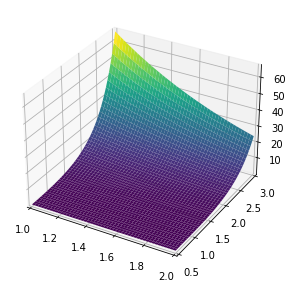

In [16]:
fig = sy.plotting.plot3d(sy.sympify(norm_grad_aggregator.data), ("x_1_0", 1, 2), ("x_1_1", 0.5, 3))
# fig.save("/home/tamara/Desktop/figure_partial_sensitivity.svg")

In [17]:
sy.sympify(norm_grad_aggregator.data).simplify(rational=True).subs({"x_1_0": 150, "x_1_1": 100})

sqrt((300 - exp(50))**2 + 4*exp(100))/5

To obtain the Lipschitz constant of the query, we need to maximise the gradient norm by minimising the negative of the norm using a suitable optimiser with a global optimality guarantee. In this case, we use SHGO as described in the paper. The norm (=sensitivity) is AOT-compiled for use with `SciPy`.

In [18]:
norm_func = se.Lambdify(list(norm_grad_aggregator.data.free_symbols), -norm_grad_aggregator.data)

SHGO minimises the function given certain constraints, in this case the bounds on the variables.

In [19]:
sol = shgo(norm_func, ((1,2), (0.5,3)))

In [20]:
sol

     fun: -66.19446391885754
    funl: array([-66.19446392])
 message: 'Optimization terminated successfully.'
    nfev: 8
     nit: 2
   nlfev: 3
   nlhev: 0
   nljev: 1
 success: True
       x: array([1., 3.])
      xl: array([[1., 3.]])

The solution to the optimisation problem (the inverse of it to be precise) is the Lipschitz constant of the function which can be used to obtain individual privacy guarantees.

In [21]:
-sol.fun # Lipschitz constant of f

66.19446391885754